# Scaling的目的
- Multi-scale learning，更robust、學習不同大小和距離的特徵
- 減少計算量

<img src="https://i.imgur.com/QngR3Qh.png" alt="drawing" width="300"/>

In [5]:
import torch.nn as nn
import os
import numpy as np
from utils import show_image_mask
import cv2
import torch
import matplotlib.pyplot as plt

In [6]:
import os   
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [7]:
file = os.listdir(f'{os.getcwd()}/data/capsule/test/scratch/')
file = np.random.choice(file,size=1, replace=False)
file = [i.split('.')[0] for i in file]
file

['017']

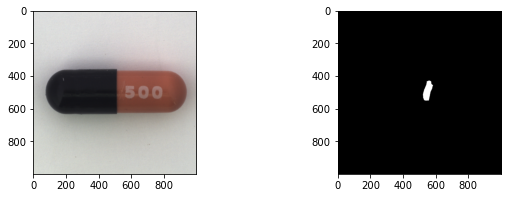

In [8]:
img_mask_list = []
for i in file:
    image = cv2.imread(f'{os.getcwd()}/data/capsule/test/scratch/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(f'{os.getcwd()}/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
#     mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
    img_mask_list.append((image, mask))
    show_image_mask(image, mask)

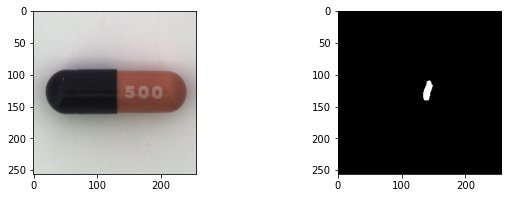

In [9]:
image = cv2.resize(image, (256,256))
mask = cv2.resize(mask, (256,256))
show_image_mask(image, mask)

## 上採樣
- 把影像的解析度放大
- resize到更大的解析度
- 最好是可以學的
- 不能學習的情況通常用通常用雙線性插值

In [10]:
# # to torch Tensor
# x = torch.Tensor(image)
# x = x.unsqueeze(0).permute(0,3,1,2)
# x.shape

In [11]:
x = torch.randn(1, 3, 28, 28)
# x = torch.Tensor(image)
# x = x.unsqueeze(0).permute(0,3,1,2)
print(x.shape)
x = nn.Upsample(scale_factor=2)(x)
x = nn.Conv2d(3, 9, kernel_size=3, padding='same')(x)
print(x.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 9, 56, 56])


In [12]:
x = torch.randn(1, 3, 56, 56)
x, indice = nn.MaxPool2d(kernel_size=2, return_indices=True)(x)
print(x.shape)
x = nn.MaxUnpool2d(2)(x, indice)
x = nn.Conv2d(3, 9, kernel_size=3, padding='same')(x)
print(x.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 9, 56, 56])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:693: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


### Transposed Conv and UpsampleConv
<img src="https://i.imgur.com/eIIJxre.png" alt="drawing" width="300"/>
<img src="https://i.imgur.com/uLo7icF.png" alt="drawing" width="300"/>

Transposed Conv 
- 透過上面的操作做轉置卷積，feature-map上的數值會作為常數與kernel相乘，產出輸出的feature-map

UpsampleConv
- 先做上採樣(Upsample/ Unpooling)
- 然後作卷積(padding = same)
<!-- #### 替代方案 UpSampling(Unpooling)+Convolution -->


In [13]:
# ConvTranspose2d透過設定k=2, s=2, output_padding=0可以讓影像從28x28變成56x56
x = torch.randn(1, 3, 28, 28)
print(x.shape)
x = nn.ConvTranspose2d(3, 3, kernel_size=2, stride=2, output_padding=0)(x)
x = nn.Conv2d(3, 9, kernel_size=3, padding='same')(x)
print(x.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 9, 56, 56])


## 下採樣
- Pooling
- Dilated Conv

### 1. Pooling

max pool，用max filter快速計算進行池化減少後續計算量，一般沒有特別考慮時可以使用的下採樣選擇

In [14]:
x = torch.randn(1, 3, 56, 56)
print(x.shape)
x= nn.MaxPool2d(kernel_size=2,)(x)
print(x.shape)

torch.Size([1, 3, 56, 56])
torch.Size([1, 3, 28, 28])


average pool，一種sum pooling，由於梯度會通過filter的每一個indice(max pooling的情況只會通過max indice)，所以DenseNet等論文特別採用他

In [15]:
x = torch.randn(1, 3, 56, 56)
print(x.shape)
x= nn.AvgPool2d(kernel_size=2,)(x)
print(x.shape)

torch.Size([1, 3, 56, 56])
torch.Size([1, 3, 28, 28])


### 2. Dilated Conv. instead of pooling

In [16]:
x = torch.randn(1, 3, 56, 56)
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=1, dilation=(1,1))(x)
x.shape

torch.Size([1, 9, 28, 28])

In [17]:
x = torch.randn(1, 3, 56, 56)
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=3, dilation=(3,3))(x)
x.shape

torch.Size([1, 9, 28, 28])

In [18]:
x = torch.randn(1, 3, 56, 56)
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=5, dilation=(5,5))(x)
x.shape

torch.Size([1, 9, 28, 28])

In [19]:
dilated_rate = [1,2,3] 
dilatedConv = lambda rate:nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=rate, dilation=(rate,rate))
for idx in range(3):
    x = torch.randn(1, 3, 56, 56)
    print(f'padding = {dilated_rate[idx]}, dilation=({dilated_rate[idx]},{dilated_rate[idx]})')
    x = dilatedConv(dilated_rate[idx%3])(x)
    print(x.shape)

padding = 1, dilation=(1,1)
torch.Size([1, 9, 28, 28])
padding = 2, dilation=(2,2)
torch.Size([1, 9, 28, 28])
padding = 3, dilation=(3,3)
torch.Size([1, 9, 28, 28])


In [20]:
dilated_rate = [1,2,3]
dilatedConv = lambda rate:nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=rate, dilation=(rate,rate))
dilated_convBlock = nn.ModuleList([dilatedConv(i) for i in dilated_rate])

# x = torch.Tensor(mask)
# x = x[...,None,None].permute(2,3,0,1)
x = torch.randn(1, 1, 56, 56)
print(x.shape)
for i in dilated_convBlock:
    x = i(x)
    print(x.shape)
# x = dilated_convBlock(x)
# x.shape

torch.Size([1, 1, 56, 56])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 7, 7])
